# Recipe recommendation model



# **Download and Load Dataset**

In [1]:
import kagglehub
path = kagglehub.dataset_download('pes12017000148/food-ingredients-and-recipe-dataset-with-images')

print('Data source import complete.')
print("Path to dataset files:", path)

Data source import complete.
Path to dataset files: /root/.cache/kagglehub/datasets/pes12017000148/food-ingredients-and-recipe-dataset-with-images/versions/1


In [2]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel
import pickle

# **Natural Language Processing (NLP)**

In [3]:
# Load NLP model for ingredient extraction
nlp = spacy.load("en_core_web_sm")

def extract_ingredients(text):
    doc = nlp(text)
    ingredients = [token.text.lower() for token in doc if token.pos_ in ["NOUN", "PROPN"]]
    return ", ".join(ingredients)

In [4]:
# Load dataset
df = pd.read_csv(path + "/Food Ingredients and Recipe Dataset with Image Name Mapping.csv")

# Verify columns
print("Available columns:", df.columns)

print(df.describe())

Available columns: Index(['Unnamed: 0', 'Title', 'Ingredients', 'Instructions', 'Image_Name',
       'Cleaned_Ingredients'],
      dtype='object')
         Unnamed: 0
count  13501.000000
mean    6750.000000
std     3897.547327
min        0.000000
25%     3375.000000
50%     6750.000000
75%    10125.000000
max    13500.000000


In [5]:
# Select ingredient column
ingredient_col = 'Cleaned_Ingredients' if 'Cleaned_Ingredients' in df.columns else 'Ingredients'
df[ingredient_col] = df[ingredient_col].fillna("")
df['Cleaned_Ingredients']

,Cleaned_Ingredients
0,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,"['2 large egg whites', '1 pound new potatoes (..."
2,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."
...,...
13496,"['1 cup all-purpose flour', '2/3 cup unsweeten..."
13497,"['1 preserved lemon', '1 1/2 pound butternut s..."
13498,['Leftover katsuo bushi (dried bonito flakes) ...
13499,['1 stick (1/2 cup) plus 1 tablespoon unsalted...


In [6]:
# Data Analysis
print("Dataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTop 10 most common words:")
ingredient_counts = df[ingredient_col].str.split(', ').explode().value_counts().head(10)
print(ingredient_counts)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13501 entries, 0 to 13500
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           13501 non-null  int64 
 1   Title                13496 non-null  object
 2   Ingredients          13501 non-null  object
 3   Instructions         13493 non-null  object
 4   Image_Name           13501 non-null  object
 5   Cleaned_Ingredients  13501 non-null  object
dtypes: int64(1), object(5)
memory usage: 633.0+ KB

Missing Values:
Unnamed: 0             0
Title                  5
Ingredients            0
Instructions           8
Image_Name             0
Cleaned_Ingredients    0
dtype: int64

Top 10 most common words:
Cleaned_Ingredients
divided'               3813
chopped'               1887
peeled                 1466
finely chopped'        1414
thinly sliced'         1331
'Kosher salt'          1079
minced'                 808
room temper

In [7]:
# Drop rows where Title or Instructions are missing
df = df.dropna(subset=["Title", "Instructions"])

# Verify removal
print("Remaining missing values:")
print(df.isnull().sum())


Remaining missing values:
Unnamed: 0             0
Title                  0
Ingredients            0
Instructions           0
Image_Name             0
Cleaned_Ingredients    0
dtype: int64


<ipython-input-8-c5f34fff938f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ingredient_counts.index, y=ingredient_counts.values, palette='viridis')


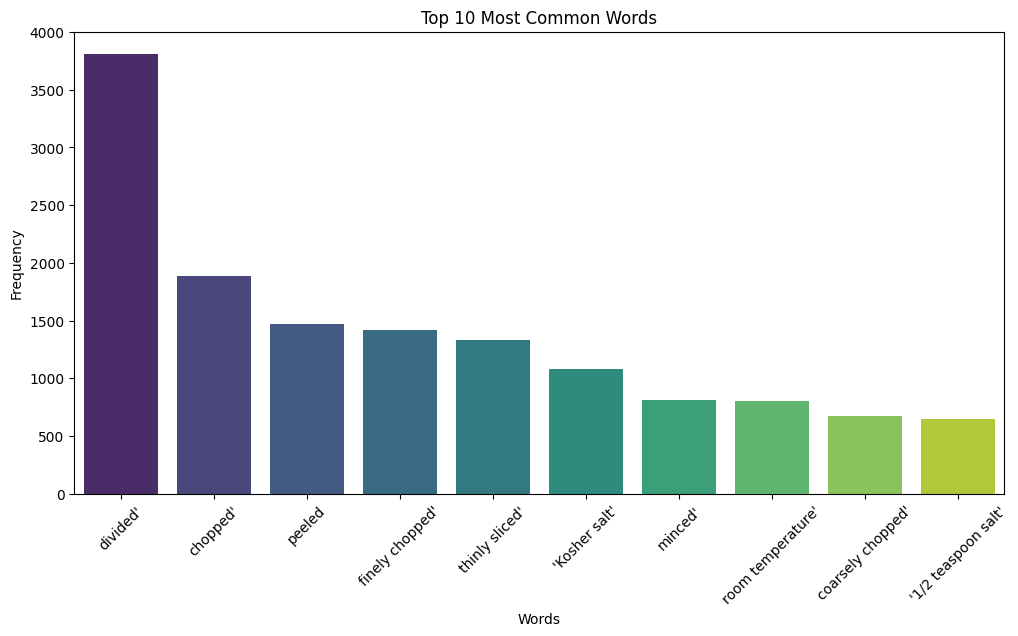

In [8]:
# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=ingredient_counts.index, y=ingredient_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 10 Most Common Words")
plt.show()

In [9]:
# TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
ingredient_vectors = vectorizer.fit_transform(df[ingredient_col])



In [10]:
# Save vectorizer and ingredient vectors
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
with open("ingredient_vectors.pkl", "wb") as f:
    pickle.dump(ingredient_vectors, f)

In [11]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ID = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_ID).to(device)
processor = CLIPProcessor.from_pretrained(model_ID)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [12]:
# Image paths
image_dir = path + "/Food Images/Food Images/"
df['Image_Path'] = df['Image_Name'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

In [13]:
# Function to display image
def show_image(image_path):
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

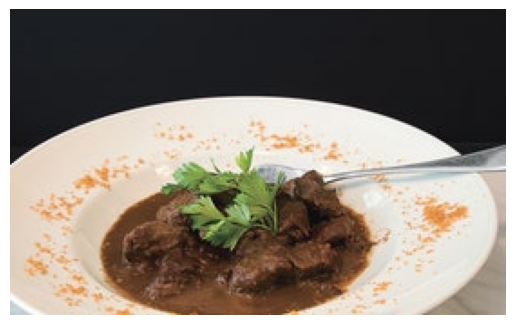

In [14]:
show_image(path + '/Food Images/Food Images/-carbonnade-a-la-flamande-short-ribs-358557.jpg')

In [15]:
# Recommendation function
def recommend_recipes(user_input, df, vectorizer, ingredient_vectors, top_n=5):
    extracted_ingredients = extract_ingredients(user_input)
    print(f"Extracted Ingredients: {extracted_ingredients}")
    input_vector = vectorizer.transform([extracted_ingredients])
    similarities = cosine_similarity(input_vector, ingredient_vectors).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]

    recommended = df.iloc[top_indices]

    for i, row in recommended.iterrows():
        print(f"\n🔹 {row['Title']}\n")
        print(f"Ingredients: {row[ingredient_col]}")
        print(f"Instructions: {row['Instructions'][:300]}...")
        show_image(row['Image_Path'])


Extracted Ingredients: meat, tomato, cabbage, home

🔹 Barbecue Pulled-Turkey Sandwiches

Ingredients: ['3 tablespoons mayonnaise', '2 teaspoons apple cider vinegar', '1/2 teaspoon celery seeds', '3 cups thinly sliced green cabbage', '2 slices applewood-smoked bacon, chopped', '1 cup tomato puree', '1/4 cup apple cider vinegar', '1/4 cup water', '3 tablespoons (packed) dark brown sugar', '1 teaspoon chili powder', '1/4 teaspoon ground cumin', '2 1/3 cups shredded cooked turkey (light and dark meat)', '4 soft rolls (such as onion', 'egg', 'sesame', 'or whole wheat)']
Instructions: Whisk mayonnaise, apple cider vinegar, and celery seeds in small bowl to blend. Season to taste with salt and pepper. Add cabbage; toss to blend. Cover bowl and chill. DO AHEAD: Can be made 1 day ahead. Cover and chill.
Sauté bacon in heavy small saucepan over medium heat until crisp and brown, abou...


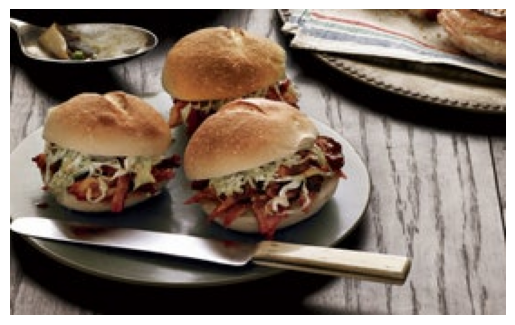


🔹 Cabbage Blue Food Dye

Ingredients: ['1/2 small head of red cabbage, coarsely chopped', '1/2 cup sugar', '1/2 teaspoon baking soda']
Instructions: Bring cabbage and 3 cups water to a simmer in a medium saucepan over medium-low heat and cook until cabbage is soft and liquid is reduced by about a third, 20–25 minutes.
Remove cabbage with a spider or slotted spoon; discard. Add sugar to cabbage liquid and simmer, swirling pan occasionally, until ...


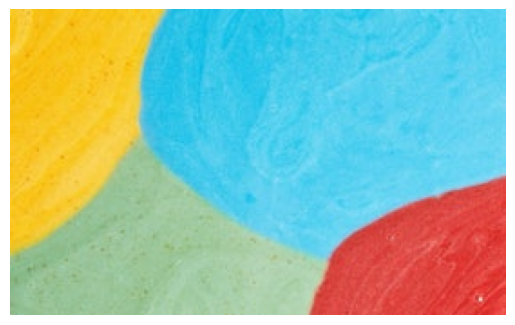


🔹 Classic Coleslaw

Ingredients: ['1 cup mayonnaise', '1 1/2 tablespoons apple cider vinegar', '1 tablespoon honey', '3/4 teaspoon celery seeds', '1 teaspoon kosher salt', '1/2 teaspoon freshly ground black pepper', '1/2 medium green cabbage, very thinly sliced (about 4 cups)', '1/2 medium red cabbage, very thinly sliced (about 4 cups)', '2 medium carrots', 'peeled; julienned or grated']
Instructions: Whisk mayonnaise, vinegar, honey, celery seeds, salt, and pepper in a large bowl to combine. Add green and red cabbage and carrots to dressing and toss to coat. Cover and chill until ready to serve.
Do ahead: Coleslaw can be made 8 hours ahead. Keep chilled....


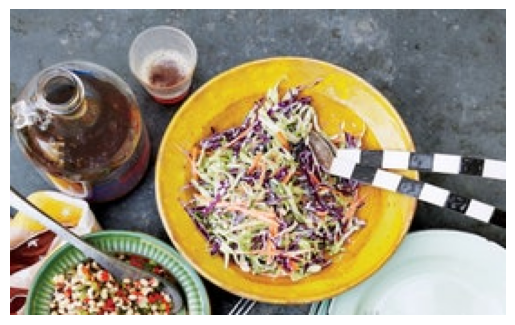


🔹 Crunchy Turkey Salad with Peanut Dressing

Ingredients: ['1/4 cup creamy peanut butter', '2 tablespoons unseasoned rice vinegar', '1 tablespoon soy sauce', '1 teaspoon Sriracha', '2 cups shredded cooked turkey meat', '1 cup shredded green or Napa cabbage', '1 cup fresh cilantro leaves with tender stems', '1 cup fresh mint leaves', '1 large carrot, shaved lengthwise with a vegetable peeler', 'Lime wedges for serving']
Instructions: Whisk 1/4 cup creamy peanut butter, 2 tablespoons unseasoned rice vinegar, 1 tablespoon soy sauce, and 1 teaspoon Sriracha in a small bowl.
Mix 2 cups shredded cooked turkey meat, 1 cup shredded green or Napa cabbage, 1 cup fresh cilantro leaves with tender stems, and 1 cup fresh mint leaves in a la...


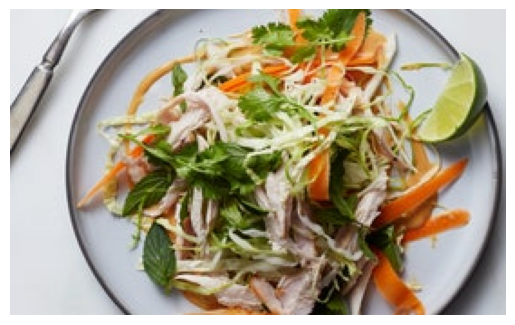


🔹 Zamosc Gefilte Fish

Ingredients: ['3 pounds carp (meat)', '1 1/2 pounds whitefish, pickerel, or rockfish (meat)', '1 1/2 pounds yellow pike or buffel (meat)', '6 onions', '2 tablespoons salt, or to taste', '6 eggs', '3 tablespoons sugar', '1 /2–1 cup matzah meal', '3/4 cup water', '1 teaspoon almond extract or 1/4 cup ground almonds (optional)', '1 1/4 teaspoons pepper', 'Horseradish (bottled or fresh)', '4 stalks celery, cut in 4-inch slices', '3 onions, sliced', '6 carrots, sliced on the bias', '8 cups water, or enough to cover bones with 1 inch to spare (use less rather than more)', 'Bones of fish (and heads, if desired)', '1 tablespoon salt', '1/2 tablespoon freshly ground pepper', '1 tablespoon sugar']
Instructions: 1. Place all the stock ingredients in a large kettle with a cover. Bring to a boil, then partially cover and reduce the heat to a simmer. While waiting for the pot to boil, begin preparing the fish.
2. In a wooden bowl, add to the ground-up fish all the other ingre

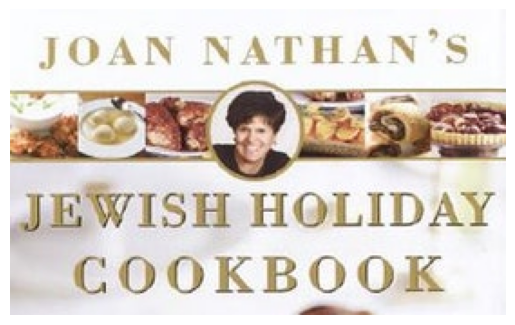

In [16]:
# Example usage
user_input = "I have meat, tomato, and cabbage at home. What can I cook?"
recommend_recipes(user_input, df, vectorizer, ingredient_vectors)